
# Pipeline de Classificação de Texto com Naive Bayes e Bag of Words

Este notebook demonstra um pipeline completo para a classificação de intenções utilizando o algoritmo Naive Bayes com vetorização Bag of Words. O pipeline inclui pré-processamento de texto, treinamento do modelo, avaliação e sugestões de melhorias.

## Sumário
1. [Setup do Ambiente](#setup-do-ambiente)
2. [Carregamento e Visualização dos Dados](#carregamento-e-visualização-dos-dados)
3. [Pré-processamento dos Textos](#pré-processamento-dos-textos)
4. [Definição das Stop Words em Português](#definição-das-stop-words-em-português)
5. [Divisão dos Dados](#divisão-dos-dados)
6. [Treinamento do Modelo](#treinamento-do-modelo)
7. [Testes e Avaliações](#testes-e-avaliações)
8. [Curva ROC](#curva-roc)
9. [Validação Cruzada](#validação-cruzada)
10. [Conclusões e Sugestões de Melhorias](#conclusões-e-sugestões-de-melhorias)

---


## Setup do Ambiente
Este passo configura o ambiente de execução, instalando as bibliotecas necessárias e importando os módulos.

In [1]:
# Instalar bibliotecas necessárias
!pip install scikit-learn matplotlib

# Importar bibliotecas
import pandas as pd
import re
import string
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import tensorflow as tf
import seaborn as sns


In [2]:
# Conectar ao Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento e Visualização dos Dados
Aqui, carregamos o arquivo de dados e verificamos suas primeiras linhas para entender sua estrutura.

In [3]:
# Carregar o arquivo Excel
file_path = '/content/drive/Shareddrives/Grupo_05/base_v1_20240828.csv'
df = pd.read_csv(file_path)

# Visualizar as primeiras linhas do DataFrame para entender a estrutura
df.head()


,No,Intencao,Pergunta,Resposta\n,Palavras_japonesas_pergunta,Palavras_japonesas_resposta,Contagem_app_pergunta,Contagem_app_resposta,Abreviacoes,perguntas_corrigidas,respostas_corrigidas
0,1,Como depositar,"['bom', 'dia', 'tudo', 'bem', 'gostar', 'saber...","['bom', 'dia', 'sim', 'senhor', 'poder', 'util...",[],[],0,0,"['eh', 'sr']",bom dia tudo bem gostar saber sobre caixa fami...,"[ ' bom ' , ' dia ' , ' sim ' , ' senhor ' , '..."
1,2,Como fazer remessa,"['enviar', 'dinheiro', 'japo']","['inscrever', 'servio', 'remessar', 'favor', '...",[],[],0,2,"['app', '24h']",enviar dinheiro japo,"[ ' inscrever ' , ' servio ' , ' remessar ' , ..."
2,3,Tempo de remessa,"['quanto', 'tempo', 'levar', 'beneficirio', 'r...","['via', 'regro', 'remessa', 'sero', 'pago', 'v...",[],[],0,0,[],quanto tempo levar beneficirio receber dinheiro,"[ ' via ' , ' regro ' , ' remesso ' , ' sero '..."
3,4,"Pedido de envio via metodo ""ByPhone""","['bom', 'tarde', 'acabar', 'fazer', 'transfern...","['ir', 'processar', 'solicitacao', 'obrigado',...",[],[],0,0,[],bom tarde acabar fazer transferncia total iene,"[ ' ir ' , ' processar ' , ' solicitacao ' , '..."
4,5,"Pedido de envio via metodo ""ByPhone""","['poder', 'fazer', 'remesso', 'iene', 'bbb', '...","['ir', 'processar', 'solicitacao', 'obrigado',...",[],[],0,0,"['bbb', 'rrr']",poder fazer remesso iene bbb rrr obrigar iene ...,"[ ' ir ' , ' processar ' , ' solicitacao ' , '..."


In [4]:
# Verificar e lidar com valores ausentes
# Substituir NaNs em 'perguntas_corrigidas' por string vazia, pode ser útil se você quiser manter essas linhas
df['perguntas_corrigidas'] = df['perguntas_corrigidas'].fillna('')

# Ou, remover linhas com NaNs em 'perguntas_corrigidas' ou 'Intencao'
df = df.dropna(subset=['perguntas_corrigidas', 'Intencao'])

## Divisão dos Dados
Dividimos o conjunto de dados em partes de treino e teste para avaliar a performance do modelo.

In [5]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df['perguntas_corrigidas'], df['Intencao'], test_size=0.3, random_state=42)


## Treinamento do Modelo
Treinamos o modelo Naive Bayes usando Bag of Words como técnica de vetorização.

In [6]:
# Função para criar e treinar o modelo
def train_model(X_train, y_train, model_type='multinomial', ngram_range=(1, 1), stop_words=None):
    if model_type == 'multinomial':
        model = MultinomialNB()
    elif model_type == 'bernoulli':
        model = BernoulliNB()
    elif model_type == 'gaussian':
        model = GaussianNB()

    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(stop_words=stop_words, ngram_range=ngram_range)),
        ('classifier', model)
    ])

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    return pipeline, train_time


In [7]:
# Verificação de tamanhos dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

# Esperado: Verificar se os tamanhos correspondem à divisão 70/30


Tamanho do conjunto de treino: 353
Tamanho do conjunto de teste: 152


In [8]:
# Treinar o modelo com o tipo de Naive Bayes escolhido
modelo_treinado, tempo_treinamento = train_model(X_train, y_train, model_type='multinomial')

print(f"Modelo treinado em {tempo_treinamento:.2f} segundos")

Modelo treinado em 0.03 segundos


## Testes e Avaliações
Aqui, realizamos testes no conjunto de dados de teste e avaliamos a performance do modelo utilizando métricas como precisão, recall e F1-score.

In [9]:
# Treinamento do modelo final
model, train_time = train_model(X_train, y_train)

# Previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliação das métricas
print("Tempo de treinamento:", train_time, "segundos")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nAcurácia:")
print(accuracy_score(y_test, y_pred))


Tempo de treinamento: 0.012216806411743164 segundos
Matriz de Confusão:
[[ 3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  4  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  2  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  4  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 14  2  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 31  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0 17  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  1  3  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  4  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  4  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  0  0]
 [ 0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Comparação CPU/GPU (opcional, dependendo do ambiente)
with tf.device('/GPU:0'):
    model_gpu, train_time_gpu = train_model(X_train, y_train)
print("Tempo de treinamento com GPU:", train_time_gpu, "segundos")
print("Diferença de tempo CPU vs GPU:", train_time - train_time_gpu, "segundos")


Tempo de treinamento com GPU: 0.013502836227416992 segundos
Diferença de tempo CPU vs GPU: -0.0012860298156738281 segundos


## Curva ROC
Geramos e visualizamos a curva ROC para avaliar a qualidade das previsões do modelo.

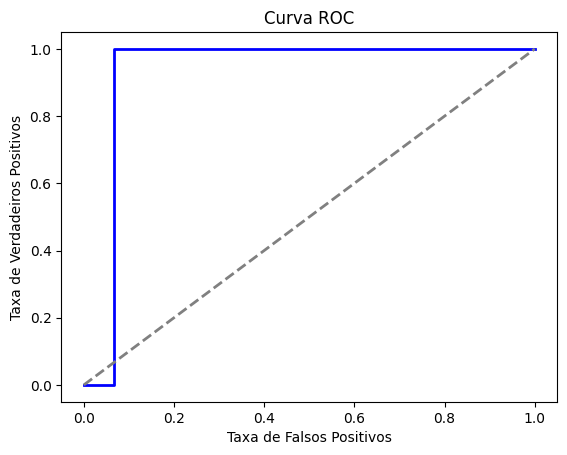

In [11]:
# Curva ROC (exemplo para MultinomialNB)
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=model.classes_[1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.show()


## Validação Cruzada
Aplicamos a técnica de validação cruzada (K-fold) para verificar a robustez do modelo.

In [12]:
# K-fold Cross Validation para verificação de desempenho
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train, y_train, cv=kf)
print(f"Cross-validation accuracy scores: {cross_val_scores}")


Cross-validation accuracy scores: [0.6056338  0.5915493  0.57746479 0.51428571 0.6       ]


# Gráficos das Métricas


In [13]:


# Ajustar os arrays para garantir que ambos tenham o mesmo número de amostras
min_length = min(len(y_test), len(y_pred))
y_test = y_test[:min_length]
y_pred = y_pred[:min_length]

# Obter as labels únicas e ordená-las
labels = sorted(list(set(y_test)))



## Matriz de Confusão

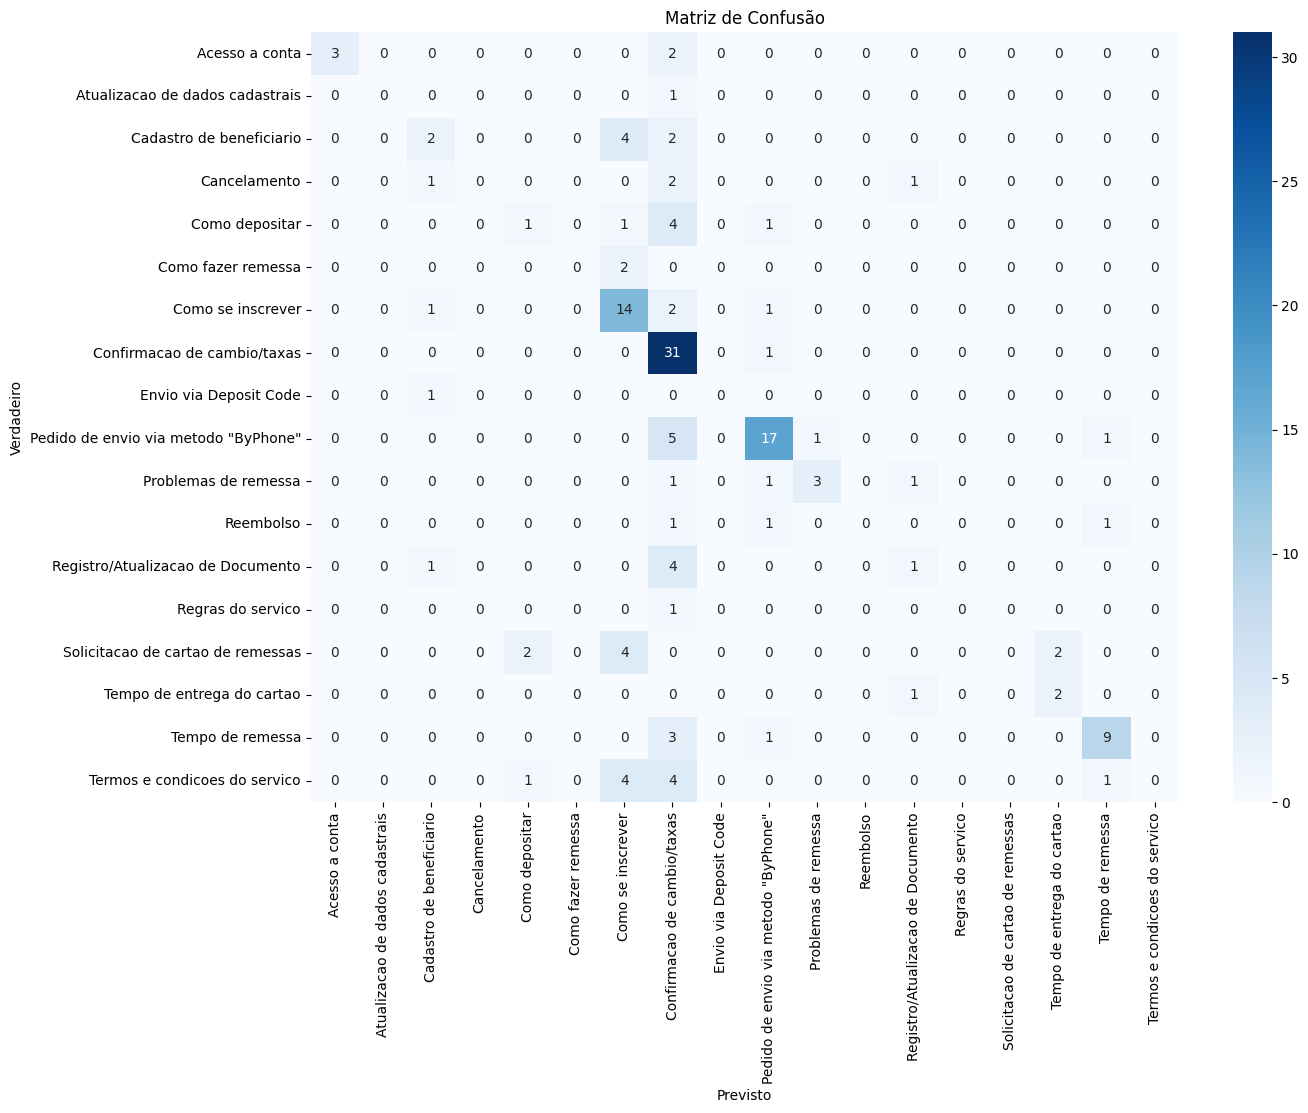

In [14]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()


## Métricas de Classificação por Classe

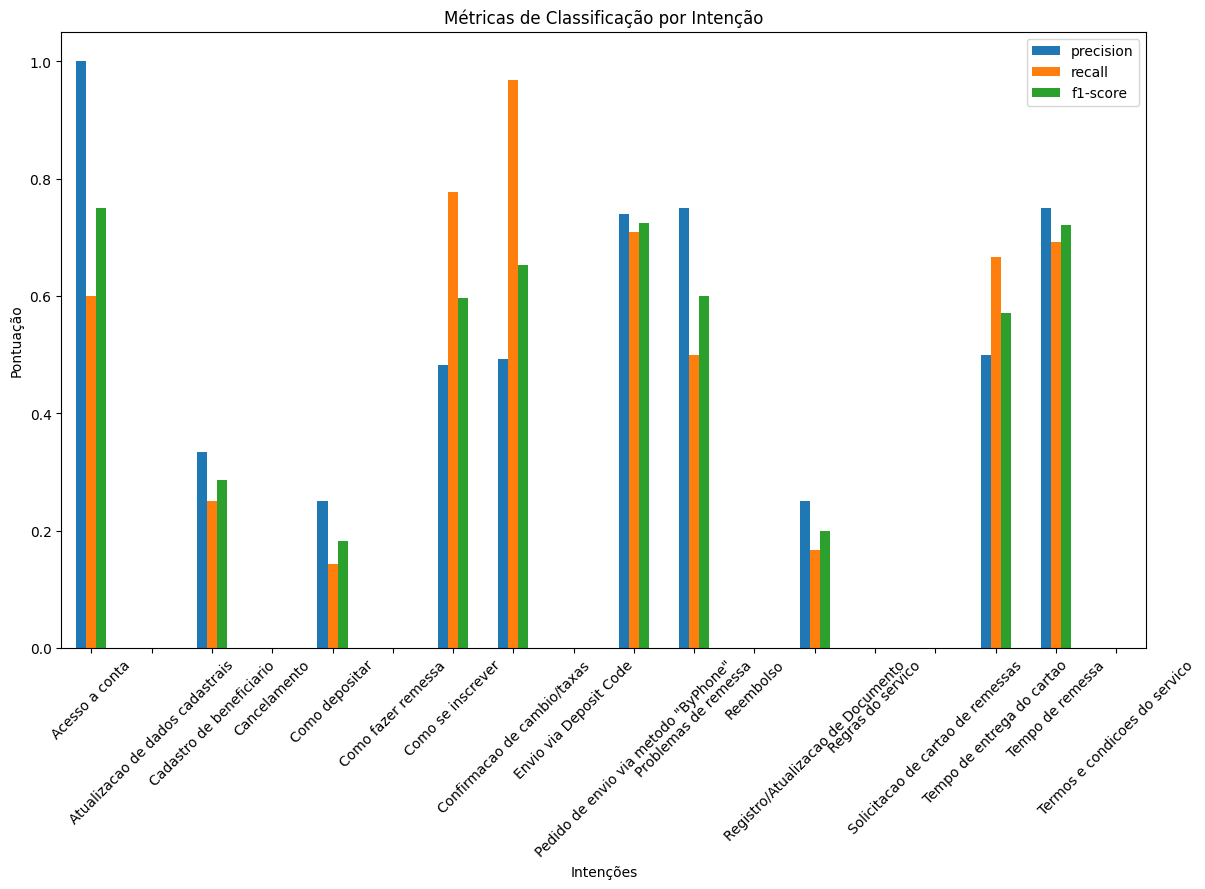

In [15]:
# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, labels=labels, output_dict=True, zero_division=0)
metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :3]  # Ignorar a última linha que não é relevante

# Plotar as métricas
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Métricas de Classificação por Intenção')
plt.ylabel('Pontuação')
plt.xlabel('Intenções')
plt.xticks(rotation=45)
plt.show()